## Derive daily soil temperature for each of the five sites across the climate gradient

By Bin Wang (@bioatmo_sphere)

---

**Data source**: https://github.com/stevenallison/UCIClimateExperiment/tree/master/updatednames

**Code Reference**: https://github.com/stevenallison/UCIClimateExperiment/blob/master/Tempdata_ibutton_figures.R

**Note**: soil temperature at the surface is assumed to be equal to litter temperture.

In [1]:
#library(reshape)
#library(lattice)
library(plyr)
library(stringr)
library(chron)

In [2]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-apple-darwin15.6.0 (64-bit)
Running under: macOS High Sierra 10.13.6

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/3.6/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/3.6/Resources/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] chron_2.3-56  stringr_1.4.0 plyr_1.8.6   

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.4      digest_0.6.25   crayon_1.3.4    IRdisplay_0.7.0
 [5] repr_1.1.0      jsonlite_1.6.1  magrittr_1.5    evaluate_0.14  
 [9] pillar_1.4.3    stringi_1.4.6   rlang_0.4.7     uuid_0.1-4     
[13] IRkernel_1.1    tools_3.6.3     compiler_3.6.3  base64enc_0.1-3
[17] htmltools_0.4.0 pbdZMQ_0.3-3   

In [3]:
#####################################################################
########Make a function to make a data frame for temperatures
#####################################################################
maketempdataframe <- function(plot1,plot4,sitename){
  #find unique values/remove duplicate dates from plot 1 and plot4
  plot1.unique <- unique(plot1, by = "Date.Time")
  plot4.unique <- unique(plot4, by = "Date.Time")
  #do the rows equal each other?
  nrow(plot1.unique) == nrow(plot4.unique)
  #add in a if else conditional statement to do nothing if the rows are the same but to add the last row of plot 4 to the plot1 if they aren't
  #because what happened in these plots is that there was a sampling time point taken after noon in plot 4 but not in plot1 so there is one less sample
  if(nrow(plot1.unique) != nrow(plot4.unique)) plot1.unique <- rbind(plot1.unique,tail(plot4.unique, n=1)) else plot1.unique <- plot1.unique
  
  #bind together columns for plots 1 and plot 4
  combo.temp <- cbind(plot1.unique,plot4.unique)
  #rename columns
  names(combo.temp) <- c("Date.Time","Unit","Value.Plot1","Date.Time.Plot4","Unit.Plot4","Value.Plot4")
  ###realized that plot 1 is on the :01 minute and plot 4 is on the :02 minute so need to remove the minutes so they can match
  combo.temp.times <- ldply(str_split(string = combo.temp$Date.Time, pattern=":"), rbind) # Divide a column using ";"and convert list to data frame
  combo.temp$Date.Month.Year.Hour <- combo.temp.times[,1 ]
  #now get a column of just the hours
  combo.hours <- ldply(str_split(string = combo.temp$Date.Month.Year.Hour, pattern=" "), rbind) 
  combo.temp$hour <- combo.hours[,2]  
  #get a column of just the dates
  combo.temp$Date <- as.Date(combo.temp$Date.Time, format="%m/%d/%Y")
  #get column of just months
  combo.temp$month <- months(combo.temp$Date, abbreviate=TRUE)
  #get column of just years
  combo.temp$year <- years(combo.temp$Date)
  #get a column for the day of the month
  combo.temp$days <- days(combo.temp$Date)
  #get date and time in a nice format R likes
  combo.temp$DateandTime <- as.POSIXct(combo.temp$Date.Time, format="%m/%d/%Y %H:%M")
  #calculate mean site temperature
  combo.temp$Value.Mean <- (combo.temp$Value.Plot1+combo.temp$Value.Plot4)/2
  #make a day night column
  #make a column that assigns to day or night based on the hour
  #day times are 11am, noon, 3pm, 4pm, night times are everything else
  combo.temp$daynight <- "night"
  combo.temp$daynight[combo.temp$hour %in% c("11","12","15","16")] <- "day"
  #make it a factor instead of a character
  combo.temp$daynight<- as.factor(combo.temp$daynight)
  #get column of just the sites 
  combo.temp$site <- rep(sitename,nrow(combo.temp))
  #make it a factor instead of a character
  combo.temp$site <- as.factor(combo.temp$site)
  #return the dataframe
  return(combo.temp)
}

## Desert
upload all of the desert data plot 1, rbind, remove duplicate rows, then average with plot 4

In [4]:
desert.data.plot1.3 <- read.csv("soil_temperature/desert_plot1_04-20-17-2.csv", skip=14)
desert.data.plot1.2 <- read.csv("soil_temperature/desert_plot1_10-23-16-2.csv", skip=14)
desert.data.plot1.1 <- read.csv("soil_temperature/desert_plot1_06-16-2.csv",    skip=14)

desert.data.plot4.3 <- read.csv("soil_temperature/desert_plot4_04-20-17-2.csv", skip=14)
desert.data.plot4.2 <- read.csv("soil_temperature/desert_plot4_10-23-16-2.csv", skip=14)
desert.data.plot4.1 <- read.csv("soil_temperature/desert_plot4_06_16-2.csv",    skip=14)

In [5]:
#bind together the 3 time points from desert plot 1
desertplot1 <- rbind(desert.data.plot1.1,desert.data.plot1.2,desert.data.plot1.3 )
nrow(desertplot1)
#3696

[1] 3696

In [6]:
#find unique rows by a certaim column "date.time"
desertplot1.unique <- unique(desertplot1, by = "Date.Time")
nrow(desertplot1.unique) #2286

[1] 2286

In [7]:
#bind together the 3 time points from desert plot 4
desertplot4 <- rbind(desert.data.plot4.1,desert.data.plot4.2,desert.data.plot4.3 )
nrow(desertplot4)
#3696
plot4.unique <- unique(desertplot4, by = "Date.Time")
nrow(plot4.unique)
#2286

[1] 3696

[1] 2286

In [8]:
##apply function to get desert data frame
desert.temp <- maketempdataframe(desertplot1, desertplot4,"Desert")

In [9]:
head(desert.temp)

,Date.Time,Unit,Value.Plot1,Date.Time.Plot4,Unit.Plot4,Value.Plot4,Date.Month.Year.Hour,hour,Date,month,year,days,DateandTime,Value.Mean,daynight,site
,<fct>,<fct>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<fct>,<date>,<chr>,<ord>,<ord>,<dttm>,<dbl>,<fct>,<fct>
1,4/4/16 12:01,C,22.0,4/4/16 12:02,C,22.5,4/4/16 12,12,0016-04-04,Apr,16,4,0016-04-04 12:01:00,22.25,day,Desert
2,4/4/16 16:01,C,22.0,4/4/16 16:02,C,22.5,4/4/16 16,16,0016-04-04,Apr,16,4,0016-04-04 16:01:00,22.25,day,Desert
3,4/4/16 20:01,C,22.5,4/4/16 20:02,C,22.5,4/4/16 20,20,0016-04-04,Apr,16,4,0016-04-04 20:01:00,22.50,night,Desert
4,4/5/16 0:01,C,23.0,4/5/16 0:02,C,23.0,4/5/16 0,0,0016-04-05,Apr,16,5,0016-04-05 00:01:00,23.00,night,Desert
5,4/5/16 4:01,C,22.5,4/5/16 4:02,C,22.5,4/5/16 4,4,0016-04-05,Apr,16,5,0016-04-05 04:01:00,22.50,night,Desert
6,4/5/16 8:01,C,23.0,4/5/16 8:02,C,23.0,4/5/16 8,8,0016-04-05,Apr,16,5,0016-04-05 08:01:00,23.00,night,Desert


In [10]:
desert.temp0 <- desert.temp[c('Date','Value.Mean')]
head(desert.temp0)

,Date,Value.Mean
,<date>,<dbl>
1,0016-04-04,22.25
2,0016-04-04,22.25
3,0016-04-04,22.50
4,0016-04-05,23.00
5,0016-04-05,22.50
6,0016-04-05,23.00


**Derive mean value by date**

Code Reference:https://stackoverflow.com/questions/21982987/mean-per-group-in-a-data-frame/28677167

In [11]:
desert.temp1 <- ddply(desert.temp0, .(Date), summarize,  Mean=mean(Value.Mean))
head(desert.temp1)

,Date,Mean
,<date>,<dbl>
1,0016-04-04,22.33333
2,0016-04-05,23.62500
3,0016-04-06,31.83333
4,0016-04-07,26.79167
5,0016-04-08,21.04167
6,0016-04-09,19.91667


In [12]:
desert.temp1$Date

[1] "0016-04-04" "0016-04-05" "0016-04-06" "0016-04-07" "0016-04-08"
  [6] "0016-04-09" "0016-04-10" "0016-04-11" "0016-04-12" "0016-04-13"
 [11] "0016-04-14" "0016-04-15" "0016-04-16" "0016-04-17" "0016-04-18"
 [16] "0016-04-19" "0016-04-20" "0016-04-21" "0016-04-22" "0016-04-23"
 [21] "0016-04-24" "0016-04-25" "0016-04-26" "0016-04-27" "0016-04-28"
 [26] "0016-04-29" "0016-04-30" "0016-05-01" "0016-05-02" "0016-05-03"
 [31] "0016-05-04" "0016-05-05" "0016-05-06" "0016-05-07" "0016-05-08"
 [36] "0016-05-09" "0016-05-10" "0016-05-11" "0016-05-12" "0016-05-13"
 [41] "0016-05-14" "0016-05-15" "0016-05-16" "0016-05-17" "0016-05-18"
 [46] "0016-05-19" "0016-05-20" "0016-05-21" "0016-05-22" "0016-05-23"
 [51] "0016-05-24" "0016-05-25" "0016-05-26" "0016-05-27" "0016-05-28"
 [56] "0016-05-29" "0016-05-30" "0016-05-31" "0016-06-01" "0016-06-02"
 [61] "0016-06-03" "0016-06-04" "0016-06-05" "0016-06-06" "0016-06-07"
 [66] "0016-06-08" "0016-06-09" "0016-06-10" "0016-06-11" "0016-06-12"
 [71] "0016-06-13" "0016-06-14" "0016-06-15" "0016-06-16" "0016-06-17"
 [76] "0016-06-18" "0016-06-19" "0016-06-20" "0016-06-21" "0016-06-22"
 [81] "0016-06-23" "0016-06-24" "0016-06-25" "0016-06-26" "0016-06-27"
 [86] "0016-06-28" "0016-06-29" "0016-06-30" "0016-07-01" "0016-07-02"
 [91] "0016-07-03" "0016-07-04" "0016-07-05" "0016-07-06" "0016-07-07"
 [96] "0016-07-08" "0016-07-09" "0016-07-10" "0016-07-11" "0016-07-12"
[101] "0016-07-13" "0016-07-14" "0016-07-15" "0016-07-16" "0016-07-17"
[106] "0016-07-18" "0016-07-19" "0016-07-20" "0016-07-21" "0016-07-22"
[111] "0016-07-23" "0016-07-24" "0016-07-25" "0016-07-26" "0016-07-27"
[116] "0016-07-28" "0016-07-29" "0016-07-30" "0016-07-31" "0016-08-01"
[121] "0016-08-02" "0016-08-03" "0016-08-04" "0016-08-05" "0016-08-06"
[126] "0016-08-07" "0016-08-08" "0016-08-09" "0016-08-10" "0016-08-11"
[131] "0016-08-12" "0016-08-13" "0016-08-14" "0016-08-15" "0016-08-16"
[136] "0016-08-17" "0016-08-18" "0016-08-19" "0016-08-20" "0016-08-21"
[141] "0016-08-22" "0016-08-23" "0016-08-24" "0016-08-25" "0016-08-26"
[146] "0016-08-27" "0016-08-28" "0016-08-29" "0016-08-30" "0016-08-31"
[151] "0016-09-01" "0016-09-02" "0016-09-03" "0016-09-04" "0016-09-05"
[156] "0016-09-06" "0016-09-07" "0016-09-08" "0016-09-09" "0016-09-10"
[161] "0016-09-11" "0016-09-12" "0016-09-13" "0016-09-14" "0016-09-15"
[166] "0016-09-16" "0016-09-17" "0016-09-18" "0016-09-19" "0016-09-20"
[171] "0016-09-21" "0016-09-22" "0016-09-23" "0016-09-24" "0016-09-25"
[176] "0016-09-26" "0016-09-27" "0016-09-28" "0016-09-29" "0016-09-30"
[181] "0016-10-01" "0016-10-02" "0016-10-03" "0016-10-04" "0016-10-05"
[186] "0016-10-06" "0016-10-07" "0016-10-08" "0016-10-09" "0016-10-10"
[191] "0016-10-11" "0016-10-12" "0016-10-13" "0016-10-14" "0016-10-15"
[196] "0016-10-16" "0016-10-17" "0016-10-18" "0016-10-19" "0016-10-20"
[201] "0016-10-21" "0016-10-22" "0016-10-23" "0016-10-24" "0016-10-25"
[206] "0016-10-26" "0016-10-27" "0016-10-28" "0016-10-29" "0016-10-30"
[211] "0016-10-31" "0016-11-01" "0016-11-02" "0016-11-03" "0016-11-04"
[216] "0016-11-05" "0016-11-06" "0016-11-07" "0016-11-08" "0016-11-09"
[221] "0016-11-10" "0016-11-11" "0016-11-12" "0016-11-13" "0016-11-14"
[226] "0016-11-15" "0016-11-16" "0016-11-17" "0016-11-18" "0016-11-19"
[231] "0016-11-20" "0016-11-21" "0016-11-22" "0016-11-23" "0016-11-24"
[236] "0016-11-25" "0016-11-26" "0016-11-27" "0016-11-28" "0016-11-29"
[241] "0016-11-30" "0016-12-01" "0016-12-02" "0016-12-03" "0016-12-04"
[246] "0016-12-05" "0016-12-06" "0016-12-07" "0016-12-08" "0016-12-09"
[251] "0016-12-10" "0016-12-11" "0016-12-12" "0016-12-13" "0016-12-14"
[256] "0016-12-15" "0016-12-16" "0016-12-17" "0016-12-18" "0016-12-19"
[261] "0016-12-20" "0016-12-21" "0016-12-22" "0016-12-23" "0016-12-24"
[266] "0016-12-25" "0016-12-26" "0016-12-27" "0016-12-28" "0016-12-29"
[271] "0016-12-30" "0016-12-31" "0017-01-01" "0017-01-02" "0017-01-03"
[276] "0017-01-04" "0017-01-05" "0017-01-06" "0017-01-07" "0017-01-08"
[281] "0017-01-09" "0017-0

In [13]:
index1 <- desert.temp1$Date>='0017-01-01' & desert.temp1$Date<='0017-04-03'
index2 <- desert.temp1$Date<='0016-12-31'

In [14]:
desert_temp <- rbind(desert.temp1[index1,], desert.temp1[index2,])
head(desert_temp)

,Date,Mean
,<date>,<dbl>
273,0017-01-01,11.416667
274,0017-01-02,9.958333
275,0017-01-03,9.375000
276,0017-01-04,9.666667
277,0017-01-05,13.916667
278,0017-01-06,12.166667


In [15]:
rownames(desert_temp) <- 1:365
head(desert_temp)

,Date,Mean
,<date>,<dbl>
1,0017-01-01,11.416667
2,0017-01-02,9.958333
3,0017-01-03,9.375000
4,0017-01-04,9.666667
5,0017-01-05,13.916667
6,0017-01-06,12.166667


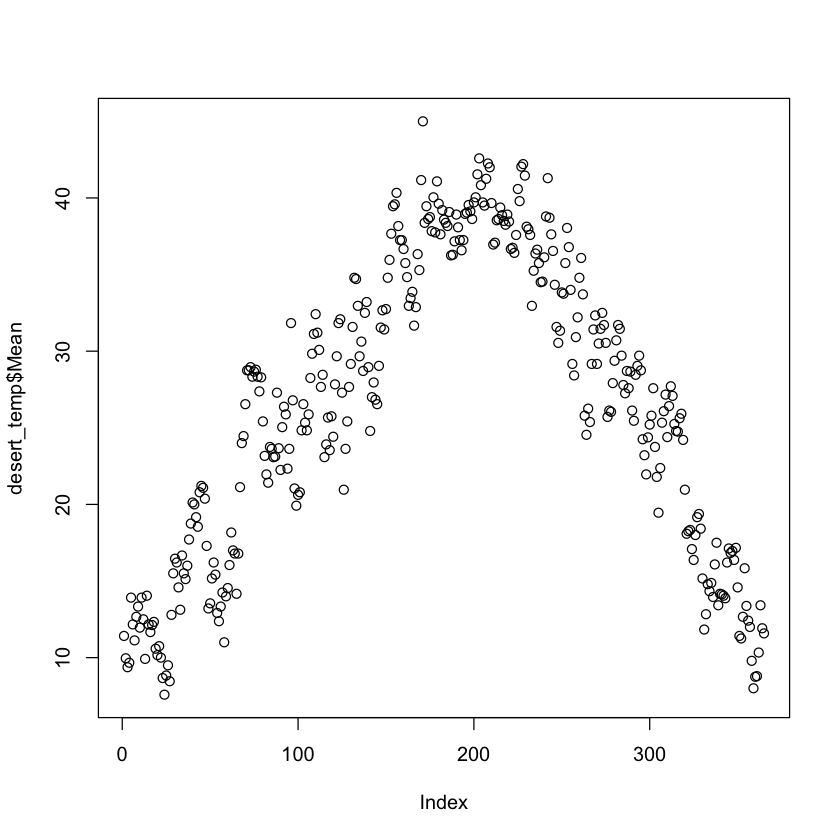

In [16]:
plot(desert_temp$Mean)

## `Scrubland`

In [17]:
scrubland.data.plot1.3 <- read.csv("soil_temperature/scrubland_plot1_04-20-17-2.csv", skip=14)
scrubland.data.plot1.2 <- read.csv("soil_temperature/scrubland_plot1_10-23_16-2.csv", skip=14)
scrubland.data.plot1.1 <- read.csv("soil_temperature/scrubland_plot1_06_16-2.csv",    skip=14)

scrubland.data.plot4.3 <- read.csv("soil_temperature/scrubland_plot4_04-20-17-2.csv", skip=14)
scrubland.data.plot4.2 <- read.csv("soil_temperature/scrubland_plot4_10-23-16-2.csv", skip=14)
scrubland.data.plot4.1 <- read.csv("soil_temperature/scrubland_plot4_06-16-2.csv",    skip=14)

In [18]:
scrublandplot1 <- rbind(scrubland.data.plot1.1,scrubland.data.plot1.2,scrubland.data.plot1.3 )
head(scrublandplot1)

,Date.Time,Unit,Value
,<fct>,<fct>,<dbl>
1,4/4/16 12:02,C,22.5
2,4/4/16 16:02,C,22.5
3,4/4/16 20:02,C,23.0
4,4/5/16 0:02,C,23.0
5,4/5/16 4:02,C,23.0
6,4/5/16 8:02,C,23.0


In [19]:
scrublandplot4 <- rbind(scrubland.data.plot4.1,scrubland.data.plot4.2,scrubland.data.plot4.3 )
head(scrublandplot4)

,Date.Time,Unit,Value
,<fct>,<fct>,<dbl>
1,4/4/16 12:01,C,22.5
2,4/4/16 16:01,C,22.5
3,4/4/16 20:01,C,22.5
4,4/5/16 0:01,C,23.0
5,4/5/16 4:01,C,23.0
6,4/5/16 8:01,C,23.0


In [20]:
scrubland.temp <- maketempdataframe(scrublandplot1, scrublandplot4,"Scrubland")
head(scrubland.temp)

,Date.Time,Unit,Value.Plot1,Date.Time.Plot4,Unit.Plot4,Value.Plot4,Date.Month.Year.Hour,hour,Date,month,year,days,DateandTime,Value.Mean,daynight,site
,<fct>,<fct>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<fct>,<date>,<chr>,<ord>,<ord>,<dttm>,<dbl>,<fct>,<fct>
1,4/4/16 12:02,C,22.5,4/4/16 12:01,C,22.5,4/4/16 12,12,0016-04-04,Apr,16,4,0016-04-04 12:02:00,22.50,day,Scrubland
2,4/4/16 16:02,C,22.5,4/4/16 16:01,C,22.5,4/4/16 16,16,0016-04-04,Apr,16,4,0016-04-04 16:02:00,22.50,day,Scrubland
3,4/4/16 20:02,C,23.0,4/4/16 20:01,C,22.5,4/4/16 20,20,0016-04-04,Apr,16,4,0016-04-04 20:02:00,22.75,night,Scrubland
4,4/5/16 0:02,C,23.0,4/5/16 0:01,C,23.0,4/5/16 0,0,0016-04-05,Apr,16,5,0016-04-05 00:02:00,23.00,night,Scrubland
5,4/5/16 4:02,C,23.0,4/5/16 4:01,C,23.0,4/5/16 4,4,0016-04-05,Apr,16,5,0016-04-05 04:02:00,23.00,night,Scrubland
6,4/5/16 8:02,C,23.0,4/5/16 8:01,C,23.0,4/5/16 8,8,0016-04-05,Apr,16,5,0016-04-05 08:02:00,23.00,night,Scrubland


In [21]:
scrubland.temp0 <- scrubland.temp[c('Date','Value.Mean')]
head(scrubland.temp0)

,Date,Value.Mean
,<date>,<dbl>
1,0016-04-04,22.50
2,0016-04-04,22.50
3,0016-04-04,22.75
4,0016-04-05,23.00
5,0016-04-05,23.00
6,0016-04-05,23.00


In [22]:
scrubland.temp1 <- ddply(scrubland.temp0, .(Date), summarize,  Mean=mean(Value.Mean))
head(scrubland.temp1)

,Date,Mean
,<date>,<dbl>
1,0016-04-04,22.58333
2,0016-04-05,21.70833
3,0016-04-06,17.87500
4,0016-04-07,15.95833
5,0016-04-08,13.04167
6,0016-04-09,11.70833


In [23]:
scrubland.temp1$Date

[1] "0016-04-04" "0016-04-05" "0016-04-06" "0016-04-07" "0016-04-08"
  [6] "0016-04-09" "0016-04-10" "0016-04-11" "0016-04-12" "0016-04-13"
 [11] "0016-04-14" "0016-04-15" "0016-04-16" "0016-04-17" "0016-04-18"
 [16] "0016-04-19" "0016-04-20" "0016-04-21" "0016-04-22" "0016-04-23"
 [21] "0016-04-24" "0016-04-25" "0016-04-26" "0016-04-27" "0016-04-28"
 [26] "0016-04-29" "0016-04-30" "0016-05-01" "0016-05-02" "0016-05-03"
 [31] "0016-05-04" "0016-05-05" "0016-05-06" "0016-05-07" "0016-05-08"
 [36] "0016-05-09" "0016-05-10" "0016-05-11" "0016-05-12" "0016-05-13"
 [41] "0016-05-14" "0016-05-15" "0016-05-16" "0016-05-17" "0016-05-18"
 [46] "0016-05-19" "0016-05-20" "0016-05-21" "0016-05-22" "0016-05-23"
 [51] "0016-05-24" "0016-05-25" "0016-05-26" "0016-05-27" "0016-05-28"
 [56] "0016-05-29" "0016-05-30" "0016-05-31" "0016-06-01" "0016-06-02"
 [61] "0016-06-03" "0016-06-04" "0016-06-05" "0016-06-06" "0016-06-07"
 [66] "0016-06-08" "0016-06-09" "0016-06-10" "0016-06-11" "0016-06-12"
 [71] "0016-06-13" "0016-06-14" "0016-06-15" "0016-06-16" "0016-06-17"
 [76] "0016-06-18" "0016-06-19" "0016-06-20" "0016-06-21" "0016-06-22"
 [81] "0016-06-23" "0016-06-24" "0016-06-25" "0016-06-26" "0016-06-27"
 [86] "0016-06-28" "0016-06-29" "0016-06-30" "0016-07-01" "0016-07-02"
 [91] "0016-07-03" "0016-07-04" "0016-07-05" "0016-07-06" "0016-07-07"
 [96] "0016-07-08" "0016-07-09" "0016-07-10" "0016-07-11" "0016-07-12"
[101] "0016-07-13" "0016-07-14" "0016-07-15" "0016-07-16" "0016-07-17"
[106] "0016-07-18" "0016-07-19" "0016-07-20" "0016-07-21" "0016-07-22"
[111] "0016-07-23" "0016-07-24" "0016-07-25" "0016-07-26" "0016-07-27"
[116] "0016-07-28" "0016-07-29" "0016-07-30" "0016-07-31" "0016-08-01"
[121] "0016-08-02" "0016-08-03" "0016-08-04" "0016-08-05" "0016-08-06"
[126] "0016-08-07" "0016-08-08" "0016-08-09" "0016-08-10" "0016-08-11"
[131] "0016-08-12" "0016-08-13" "0016-08-14" "0016-08-15" "0016-08-16"
[136] "0016-08-17" "0016-08-18" "0016-08-19" "0016-08-20" "0016-08-21"
[141] "0016-08-22" "0016-08-23" "0016-08-24" "0016-08-25" "0016-08-26"
[146] "0016-08-27" "0016-08-28" "0016-08-29" "0016-08-30" "0016-08-31"
[151] "0016-09-01" "0016-09-02" "0016-09-03" "0016-09-04" "0016-09-05"
[156] "0016-09-06" "0016-09-07" "0016-09-08" "0016-09-09" "0016-09-10"
[161] "0016-09-11" "0016-09-12" "0016-09-13" "0016-09-14" "0016-09-15"
[166] "0016-09-16" "0016-09-17" "0016-09-18" "0016-09-19" "0016-09-20"
[171] "0016-09-21" "0016-09-22" "0016-09-23" "0016-09-24" "0016-09-25"
[176] "0016-09-26" "0016-09-27" "0016-09-28" "0016-09-29" "0016-09-30"
[181] "0016-10-01" "0016-10-02" "0016-10-03" "0016-10-04" "0016-10-05"
[186] "0016-10-06" "0016-10-07" "0016-10-08" "0016-10-09" "0016-10-10"
[191] "0016-10-11" "0016-10-12" "0016-10-13" "0016-10-14" "0016-10-15"
[196] "0016-10-16" "0016-10-17" "0016-10-18" "0016-10-19" "0016-10-20"
[201] "0016-10-21" "0016-10-22" "0016-10-23" "0016-10-24" "0016-10-25"
[206] "0016-10-26" "0016-10-27" "0016-10-28" "0016-10-29" "0016-10-30"
[211] "0016-10-31" "0016-11-01" "0016-11-02" "0016-11-03" "0016-11-04"
[216] "0016-11-05" "0016-11-06" "0016-11-07" "0016-11-08" "0016-11-09"
[221] "0016-11-10" "0016-11-11" "0016-11-12" "0016-11-13" "0016-11-14"
[226] "0016-11-15" "0016-11-16" "0016-11-17" "0016-11-18" "0016-11-19"
[231] "0016-11-20" "0016-11-21" "0016-11-22" "0016-11-23" "0016-11-24"
[236] "0016-11-25" "0016-11-26" "0016-11-27" "0016-11-28" "0016-11-29"
[241] "0016-11-30" "0016-12-01" "0016-12-02" "0016-12-03" "0016-12-04"
[246] "0016-12-05" "0016-12-06" "0016-12-07" "0016-12-08" "0016-12-09"
[251] "0016-12-10" "0016-12-11" "0016-12-12" "0016-12-13" "0016-12-14"
[256] "0016-12-15" "0016-12-16" "0016-12-17" "0016-12-18" "0016-12-19"
[261] "0016-12-20" "0016-12-21" "0016-12-22" "0016-12-23" "0016-12-24"
[266] "0016-12-25" "0016-12-26" "0016-12-27" "0016-12-28" "0016-12-29"
[271] "0016-12-30" "0016-12-31" "0017-01-01" "0017-01-02" "0017-01-03"
[276] "0017-01-04" "0017-01-05" "0017-01-06" "0017-01-07" "0017-01-08"
[281] "0017-01-09" "0017-0

In [24]:
index1 <- scrubland.temp1$Date>='0017-01-01' & scrubland.temp1$Date<='0017-04-03'
index2 <- scrubland.temp1$Date<='0016-12-31'

In [25]:
scrubland_temp <- rbind(scrubland.temp1[index1,], scrubland.temp1[index2,])
head(scrubland_temp)

,Date,Mean
,<date>,<dbl>
273,0017-01-01,4.000000
274,0017-01-02,4.333333
275,0017-01-03,5.250000
276,0017-01-04,9.291667
277,0017-01-05,10.041667
278,0017-01-06,4.333333


In [26]:
rownames(scrubland_temp) <- 1:365
head(scrubland_temp)

,Date,Mean
,<date>,<dbl>
1,0017-01-01,4.000000
2,0017-01-02,4.333333
3,0017-01-03,5.250000
4,0017-01-04,9.291667
5,0017-01-05,10.041667
6,0017-01-06,4.333333


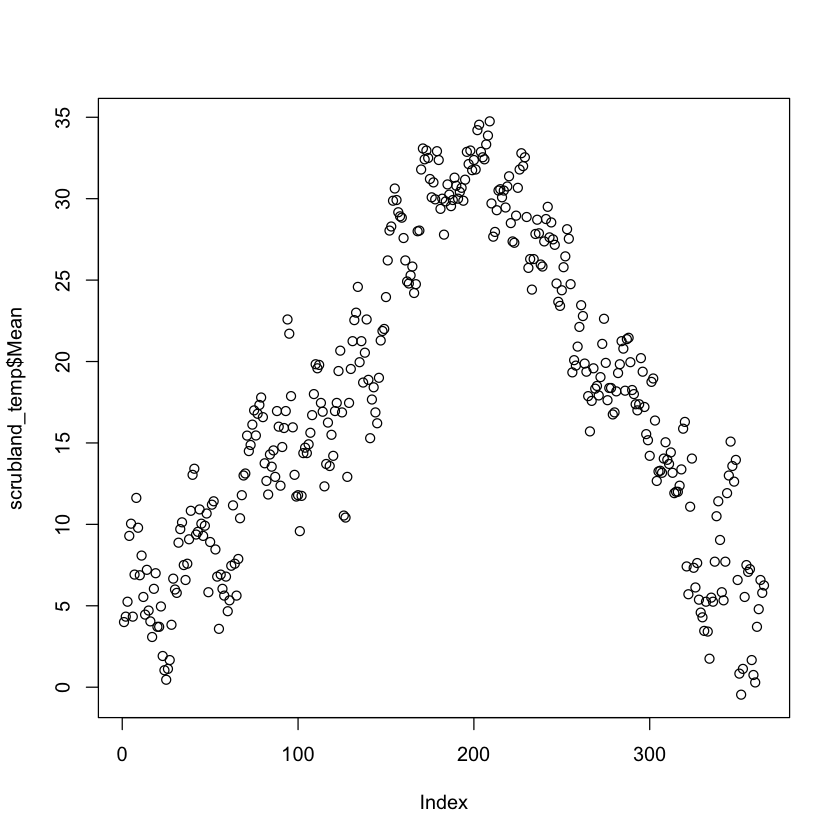

In [27]:
plot(scrubland_temp$Mean)

## `grassland`

In [28]:
grassland.data.plot1.3 <- read.csv("soil_temperature/grassland_plot1_04-20-17-2.csv", skip=14)
grassland.data.plot1.2 <- read.csv("soil_temperature/grassland_plot1_10-23-16-2.csv", skip=14)

grassland.data.plot4.3 <- read.csv("soil_temperature/grassland_plot4_4-20-17-2.csv", skip=14)
grassland.data.plot4.2 <- read.csv("soil_temperature/grassland_plot4_10-23-16-2.csv", skip=14)

In [29]:
grasslandplot1 <- rbind(grassland.data.plot1.2,grassland.data.plot1.3 )
head(grasslandplot1)

,Date.Time,Unit,Value
,<fct>,<fct>,<dbl>
1,4/4/16 12:01,C,21.5
2,4/4/16 16:01,C,21.0
3,4/4/16 20:01,C,21.0
4,4/5/16 0:01,C,21.0
5,4/5/16 4:01,C,21.0
6,4/5/16 8:01,C,21.5


In [30]:
grasslandplot4 <- rbind(grassland.data.plot4.2,grassland.data.plot4.3 )
head(grasslandplot4)

,Date.Time,Unit,Value
,<fct>,<fct>,<dbl>
1,4/4/16 12:01,C,21.5
2,4/4/16 16:01,C,21.5
3,4/4/16 20:01,C,21.5
4,4/5/16 0:01,C,21.5
5,4/5/16 4:01,C,21.5
6,4/5/16 8:01,C,21.5


In [31]:
grassland.temp <- maketempdataframe(grasslandplot1, grasslandplot4,"Grassland")
head(grassland.temp)
tail(grassland.temp)

,Date.Time,Unit,Value.Plot1,Date.Time.Plot4,Unit.Plot4,Value.Plot4,Date.Month.Year.Hour,hour,Date,month,year,days,DateandTime,Value.Mean,daynight,site
,<fct>,<fct>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<fct>,<date>,<chr>,<ord>,<ord>,<dttm>,<dbl>,<fct>,<fct>
1,4/4/16 12:01,C,21.5,4/4/16 12:01,C,21.5,4/4/16 12,12,0016-04-04,Apr,16,4,0016-04-04 12:01:00,21.50,day,Grassland
2,4/4/16 16:01,C,21.0,4/4/16 16:01,C,21.5,4/4/16 16,16,0016-04-04,Apr,16,4,0016-04-04 16:01:00,21.25,day,Grassland
3,4/4/16 20:01,C,21.0,4/4/16 20:01,C,21.5,4/4/16 20,20,0016-04-04,Apr,16,4,0016-04-04 20:01:00,21.25,night,Grassland
4,4/5/16 0:01,C,21.0,4/5/16 0:01,C,21.5,4/5/16 0,0,0016-04-05,Apr,16,5,0016-04-05 00:01:00,21.25,night,Grassland
5,4/5/16 4:01,C,21.0,4/5/16 4:01,C,21.5,4/5/16 4,4,0016-04-05,Apr,16,5,0016-04-05 04:01:00,21.25,night,Grassland
6,4/5/16 8:01,C,21.5,4/5/16 8:01,C,21.5,4/5/16 8,8,0016-04-05,Apr,16,5,0016-04-05 08:01:00,21.50,night,Grassland


,Date.Time,Unit,Value.Plot1,Date.Time.Plot4,Unit.Plot4,Value.Plot4,Date.Month.Year.Hour,hour,Date,month,year,days,DateandTime,Value.Mean,daynight,site
,<fct>,<fct>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<fct>,<date>,<chr>,<ord>,<ord>,<dttm>,<dbl>,<fct>,<fct>
3255,4/19/17 12:01,C,23.0,4/19/17 12:01,C,23,4/19/17 12,12,0017-04-19,Apr,17,19,0017-04-19 12:01:00,23.00,day,Grassland
3256,4/19/17 16:01,C,22.5,4/19/17 16:01,C,23,4/19/17 16,16,0017-04-19,Apr,17,19,0017-04-19 16:01:00,22.75,day,Grassland
3257,4/19/17 20:01,C,22.5,4/19/17 20:01,C,23,4/19/17 20,20,0017-04-19,Apr,17,19,0017-04-19 20:01:00,22.75,night,Grassland
3258,4/20/17 0:01,C,22.5,4/20/17 0:01,C,23,4/20/17 0,0,0017-04-20,Apr,17,20,0017-04-20 00:01:00,22.75,night,Grassland
3259,4/20/17 4:01,C,22.5,4/20/17 4:01,C,23,4/20/17 4,4,0017-04-20,Apr,17,20,0017-04-20 04:01:00,22.75,night,Grassland
3260,4/20/17 8:01,C,22.5,4/20/17 8:01,C,23,4/20/17 8,8,0017-04-20,Apr,17,20,0017-04-20 08:01:00,22.75,night,Grassland


In [32]:
grassland.temp0 <- grassland.temp[c('Date','Value.Mean')]
head(grassland.temp0)

,Date,Value.Mean
,<date>,<dbl>
1,0016-04-04,21.50
2,0016-04-04,21.25
3,0016-04-04,21.25
4,0016-04-05,21.25
5,0016-04-05,21.25
6,0016-04-05,21.50


In [33]:
grassland.temp1 <- ddply(grassland.temp0, .(Date), summarize,  Mean=mean(Value.Mean))
head(grassland.temp1)

,Date,Mean
,<date>,<dbl>
1,0016-04-04,21.33333
2,0016-04-05,25.45833
3,0016-04-06,19.37500
4,0016-04-07,15.16667
5,0016-04-08,14.66667
6,0016-04-09,14.37500


In [34]:
grassland.temp1$Date

[1] "0016-04-04" "0016-04-05" "0016-04-06" "0016-04-07" "0016-04-08"
  [6] "0016-04-09" "0016-04-10" "0016-04-11" "0016-04-12" "0016-04-13"
 [11] "0016-04-14" "0016-04-15" "0016-04-16" "0016-04-17" "0016-04-18"
 [16] "0016-04-19" "0016-04-20" "0016-04-21" "0016-04-22" "0016-04-23"
 [21] "0016-04-24" "0016-04-25" "0016-04-26" "0016-04-27" "0016-04-28"
 [26] "0016-04-29" "0016-04-30" "0016-05-01" "0016-05-02" "0016-05-03"
 [31] "0016-05-04" "0016-05-05" "0016-05-06" "0016-05-07" "0016-05-08"
 [36] "0016-05-09" "0016-05-10" "0016-05-11" "0016-05-12" "0016-05-13"
 [41] "0016-05-14" "0016-05-15" "0016-05-16" "0016-05-17" "0016-05-18"
 [46] "0016-05-19" "0016-05-20" "0016-05-21" "0016-05-22" "0016-05-23"
 [51] "0016-05-24" "0016-05-25" "0016-05-26" "0016-05-27" "0016-05-28"
 [56] "0016-05-29" "0016-05-30" "0016-05-31" "0016-06-01" "0016-06-02"
 [61] "0016-06-03" "0016-06-04" "0016-06-05" "0016-06-06" "0016-06-07"
 [66] "0016-06-08" "0016-06-09" "0016-06-10" "0016-06-11" "0016-06-12"
 [71] "0016-06-13" "0016-06-14" "0016-06-15" "0016-06-16" "0016-06-17"
 [76] "0016-06-18" "0016-06-19" "0016-06-20" "0016-06-21" "0016-06-22"
 [81] "0016-06-23" "0016-06-24" "0016-06-25" "0016-06-26" "0016-06-27"
 [86] "0016-06-28" "0016-06-29" "0016-06-30" "0016-07-01" "0016-07-02"
 [91] "0016-07-03" "0016-07-04" "0016-07-05" "0016-07-06" "0016-07-07"
 [96] "0016-07-08" "0016-07-09" "0016-07-10" "0016-07-11" "0016-07-12"
[101] "0016-07-13" "0016-07-14" "0016-07-15" "0016-07-16" "0016-07-17"
[106] "0016-07-18" "0016-07-19" "0016-07-20" "0016-07-21" "0016-07-22"
[111] "0016-07-23" "0016-07-24" "0016-07-25" "0016-07-26" "0016-07-27"
[116] "0016-07-28" "0016-07-29" "0016-07-30" "0016-07-31" "0016-08-01"
[121] "0016-08-02" "0016-08-03" "0016-08-04" "0016-08-05" "0016-08-06"
[126] "0016-08-07" "0016-08-08" "0016-08-09" "0016-08-10" "0016-08-11"
[131] "0016-08-12" "0016-08-13" "0016-08-14" "0016-08-15" "0016-08-16"
[136] "0016-08-17" "0016-08-18" "0016-08-19" "0016-08-20" "0016-08-21"
[141] "0016-08-22" "0016-08-23" "0016-08-24" "0016-08-25" "0016-08-26"
[146] "0016-08-27" "0016-08-28" "0016-08-29" "0016-08-30" "0016-08-31"
[151] "0016-09-01" "0016-09-02" "0016-09-03" "0016-09-04" "0016-09-05"
[156] "0016-09-06" "0016-09-07" "0016-09-08" "0016-09-09" "0016-09-10"
[161] "0016-09-11" "0016-09-12" "0016-09-13" "0016-09-14" "0016-09-15"
[166] "0016-09-16" "0016-09-17" "0016-09-18" "0016-09-19" "0016-09-20"
[171] "0016-09-21" "0016-09-22" "0016-09-23" "0016-09-24" "0016-09-25"
[176] "0016-09-26" "0016-09-27" "0016-09-28" "0016-09-29" "0016-09-30"
[181] "0016-10-01" "0016-10-02" "0016-10-03" "0016-10-04" "0016-10-05"
[186] "0016-10-06" "0016-10-07" "0016-10-08" "0016-10-09" "0016-10-10"
[191] "0016-10-11" "0016-10-12" "0016-10-13" "0016-10-14" "0016-10-15"
[196] "0016-10-16" "0016-10-17" "0016-10-18" "0016-10-19" "0016-10-20"
[201] "0016-10-21" "0016-10-22" "0016-10-23" "0016-10-24" "0016-10-25"
[206] "0016-10-26" "0016-10-27" "0016-10-28" "0016-10-29" "0016-10-30"
[211] "0016-10-31" "0016-11-01" "0016-11-02" "0016-11-03" "0016-11-04"
[216] "0016-11-05" "0016-11-06" "0016-11-07" "0016-11-08" "0016-11-09"
[221] "0016-11-10" "0016-11-11" "0016-11-12" "0016-11-13" "0016-11-14"
[226] "0016-11-15" "0016-11-16" "0016-11-17" "0016-11-18" "0016-11-19"
[231] "0016-11-20" "0016-11-21" "0016-11-22" "0016-11-23" "0016-11-24"
[236] "0016-11-25" "0016-11-26" "0016-11-27" "0016-11-28" "0016-11-29"
[241] "0016-11-30" "0016-12-01" "0016-12-02" "0016-12-03" "0016-12-04"
[246] "0016-12-05" "0016-12-06" "0016-12-07" "0016-12-08" "0016-12-09"
[251] "0016-12-10" "0016-12-11" "0016-12-12" "0016-12-13" "0016-12-14"
[256] "0016-12-15" "0016-12-16" "0016-12-17" "0016-12-18" "0016-12-19"
[261] "0016-12-20" "0016-12-21" "0016-12-22" "0016-12-23" "0016-12-24"
[266] "0016-12-25" "0016-12-26" "0016-12-27" "0016-12-28" "0016-12-29"
[271] "0016-12-30" "0016-12-31" "0017-01-01" "0017-01-02" "0017-01-03"
[276] "0017-01-04" "0017-01-05" "0017-01-06" "0017-01-07" "0017-01-08"
[281] "0017-01-09" "0017-0

In [35]:
index1 <- grassland.temp1$Date>='0017-01-01' & grassland.temp1$Date<='0017-04-03'
index2 <- grassland.temp1$Date<='0016-12-31'

grassland_temp <- rbind(grassland.temp1[index1,], grassland.temp1[index2,])
head(grassland_temp)

,Date,Mean
,<date>,<dbl>
273,0017-01-01,6.500000
274,0017-01-02,9.000000
275,0017-01-03,7.916667
276,0017-01-04,8.625000
277,0017-01-05,12.583333
278,0017-01-06,8.750000


In [36]:
rownames(grassland_temp) <- 1:365
head(grassland_temp)

,Date,Mean
,<date>,<dbl>
1,0017-01-01,6.500000
2,0017-01-02,9.000000
3,0017-01-03,7.916667
4,0017-01-04,8.625000
5,0017-01-05,12.583333
6,0017-01-06,8.750000


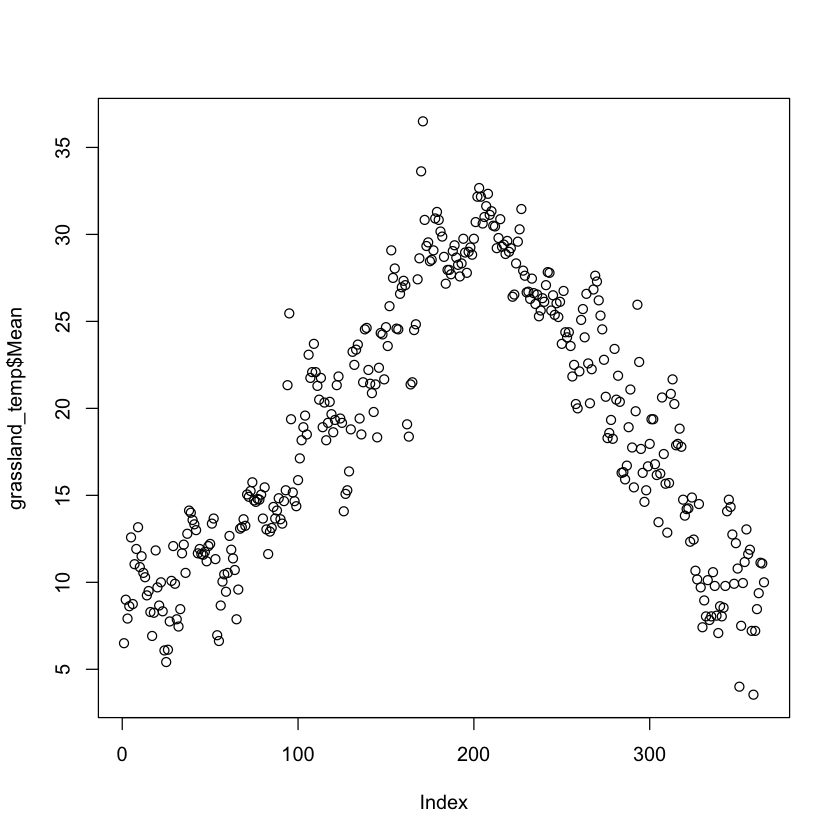

In [37]:
plot(grassland_temp$Mean)

## `Pine-Oak`

In [38]:
pineoak.data.plot1.3 <- read.csv("soil_temperature/pineoak_plot1_04-20-17-2.csv", skip=14)
pineoak.data.plot1.2 <- read.csv("soil_temperature/pineoak_plot1_10-23-16-2.csv", skip=14)
pineoak.data.plot1.1 <- read.csv("soil_temperature/pineoak_plot1_06_16-2.csv",    skip=14)

pineoak.data.plot4.3 <- read.csv("soil_temperature/pineoak_plot4_04-20-17-2.csv", skip=14)
pineoak.data.plot4.2 <- read.csv("soil_temperature/pineoak_plot4_10-23-16-2.csv", skip=14)
pineoak.data.plot4.1 <- read.csv("soil_temperature/pineoak_plot4_06-16-2.csv",    skip=14)

In [39]:
pineoakplot1 <- rbind(pineoak.data.plot1.1,pineoak.data.plot1.2,pineoak.data.plot1.3 )
head(pineoakplot1)
tail(pineoakplot1)

,Date.Time,Unit,Value
,<fct>,<fct>,<dbl>
1,4/4/16 12:01,C,22.0
2,4/4/16 16:01,C,22.5
3,4/4/16 20:01,C,22.5
4,4/5/16 0:01,C,23.0
5,4/5/16 4:01,C,22.5
6,4/5/16 8:01,C,23.0


,Date.Time,Unit,Value
,<fct>,<fct>,<dbl>
3687,4/19/17 12:01,C,20.5
3688,4/19/17 16:01,C,30.0
3689,4/19/17 20:01,C,28.0
3690,4/20/17 0:01,C,23.0
3691,4/20/17 4:01,C,19.5
3692,4/20/17 8:01,C,18.5


In [40]:
pineoakplot4 <- rbind(pineoak.data.plot4.1,pineoak.data.plot4.2,pineoak.data.plot4.3 )
head(pineoakplot4)
tail(pineoakplot4)

,Date.Time,Unit,Value
,<fct>,<fct>,<dbl>
1,4/4/16 12:01,C,22.0
2,4/4/16 16:01,C,22.5
3,4/4/16 20:01,C,22.5
4,4/5/16 0:01,C,23.0
5,4/5/16 4:01,C,22.5
6,4/5/16 8:01,C,23.0


,Date.Time,Unit,Value
,<fct>,<fct>,<dbl>
3687,4/19/17 16:01,C,30.0
3688,4/19/17 20:01,C,25.0
3689,4/20/17 0:01,C,19.5
3690,4/20/17 4:01,C,16.5
3691,4/20/17 8:01,C,17.5
3692,4/20/17 12:01,C,22.5


In [41]:
pineoak.temp <- maketempdataframe(pineoakplot1, pineoakplot4,"Pine-oak")
head(pineoak.temp)
tail(pineoak.temp)

,Date.Time,Unit,Value.Plot1,Date.Time.Plot4,Unit.Plot4,Value.Plot4,Date.Month.Year.Hour,hour,Date,month,year,days,DateandTime,Value.Mean,daynight,site
,<fct>,<fct>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<fct>,<date>,<chr>,<ord>,<ord>,<dttm>,<dbl>,<fct>,<fct>
1,4/4/16 12:01,C,22.0,4/4/16 12:01,C,22.0,4/4/16 12,12,0016-04-04,Apr,16,4,0016-04-04 12:01:00,22.0,day,Pine-oak
2,4/4/16 16:01,C,22.5,4/4/16 16:01,C,22.5,4/4/16 16,16,0016-04-04,Apr,16,4,0016-04-04 16:01:00,22.5,day,Pine-oak
3,4/4/16 20:01,C,22.5,4/4/16 20:01,C,22.5,4/4/16 20,20,0016-04-04,Apr,16,4,0016-04-04 20:01:00,22.5,night,Pine-oak
4,4/5/16 0:01,C,23.0,4/5/16 0:01,C,23.0,4/5/16 0,0,0016-04-05,Apr,16,5,0016-04-05 00:01:00,23.0,night,Pine-oak
5,4/5/16 4:01,C,22.5,4/5/16 4:01,C,22.5,4/5/16 4,4,0016-04-05,Apr,16,5,0016-04-05 04:01:00,22.5,night,Pine-oak
6,4/5/16 8:01,C,23.0,4/5/16 8:01,C,23.0,4/5/16 8,8,0016-04-05,Apr,16,5,0016-04-05 08:01:00,23.0,night,Pine-oak


,Date.Time,Unit,Value.Plot1,Date.Time.Plot4,Unit.Plot4,Value.Plot4,Date.Month.Year.Hour,hour,Date,month,year,days,DateandTime,Value.Mean,daynight,site
,<fct>,<fct>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<fct>,<date>,<chr>,<ord>,<ord>,<dttm>,<dbl>,<fct>,<fct>
3688,4/19/17 16:01,C,30.0,4/19/17 16:01,C,30.0,4/19/17 16,16,0017-04-19,Apr,17,19,0017-04-19 16:01:00,30.00,day,Pine-oak
3689,4/19/17 20:01,C,28.0,4/19/17 20:01,C,25.0,4/19/17 20,20,0017-04-19,Apr,17,19,0017-04-19 20:01:00,26.50,night,Pine-oak
3690,4/20/17 0:01,C,23.0,4/20/17 0:01,C,19.5,4/20/17 0,0,0017-04-20,Apr,17,20,0017-04-20 00:01:00,21.25,night,Pine-oak
3691,4/20/17 4:01,C,19.5,4/20/17 4:01,C,16.5,4/20/17 4,4,0017-04-20,Apr,17,20,0017-04-20 04:01:00,18.00,night,Pine-oak
3692,4/20/17 8:01,C,18.5,4/20/17 8:01,C,17.5,4/20/17 8,8,0017-04-20,Apr,17,20,0017-04-20 08:01:00,18.00,night,Pine-oak
36921,4/20/17 12:01,C,22.5,4/20/17 12:01,C,22.5,4/20/17 12,12,0017-04-20,Apr,17,20,0017-04-20 12:01:00,22.50,day,Pine-oak


In [42]:
pineoak.temp0 <- pineoak.temp[c('Date','Value.Mean')]
head(pineoak.temp0)

,Date,Value.Mean
,<date>,<dbl>
1,0016-04-04,22.0
2,0016-04-04,22.5
3,0016-04-04,22.5
4,0016-04-05,23.0
5,0016-04-05,22.5
6,0016-04-05,23.0


In [43]:
pineoak.temp1 <- ddply(pineoak.temp0, .(Date), summarize,  Mean=mean(Value.Mean))
head(pineoak.temp1)

,Date,Mean
,<date>,<dbl>
1,0016-04-04,22.333333
2,0016-04-05,21.750000
3,0016-04-06,15.208333
4,0016-04-07,10.166667
5,0016-04-08,7.541667
6,0016-04-09,5.625000


In [44]:
pineoak.temp1$Date

[1] "0016-04-04" "0016-04-05" "0016-04-06" "0016-04-07" "0016-04-08"
  [6] "0016-04-09" "0016-04-10" "0016-04-11" "0016-04-12" "0016-04-13"
 [11] "0016-04-14" "0016-04-15" "0016-04-16" "0016-04-17" "0016-04-18"
 [16] "0016-04-19" "0016-04-20" "0016-04-21" "0016-04-22" "0016-04-23"
 [21] "0016-04-24" "0016-04-25" "0016-04-26" "0016-04-27" "0016-04-28"
 [26] "0016-04-29" "0016-04-30" "0016-05-01" "0016-05-02" "0016-05-03"
 [31] "0016-05-04" "0016-05-05" "0016-05-06" "0016-05-07" "0016-05-08"
 [36] "0016-05-09" "0016-05-10" "0016-05-11" "0016-05-12" "0016-05-13"
 [41] "0016-05-14" "0016-05-15" "0016-05-16" "0016-05-17" "0016-05-18"
 [46] "0016-05-19" "0016-05-20" "0016-05-21" "0016-05-22" "0016-05-23"
 [51] "0016-05-24" "0016-05-25" "0016-05-26" "0016-05-27" "0016-05-28"
 [56] "0016-05-29" "0016-05-30" "0016-05-31" "0016-06-01" "0016-06-02"
 [61] "0016-06-03" "0016-06-04" "0016-06-05" "0016-06-06" "0016-06-07"
 [66] "0016-06-08" "0016-06-09" "0016-06-10" "0016-06-11" "0016-06-12"
 [71] "0016-06-13" "0016-06-14" "0016-06-15" "0016-06-16" "0016-06-17"
 [76] "0016-06-18" "0016-06-19" "0016-06-20" "0016-06-21" "0016-06-22"
 [81] "0016-06-23" "0016-06-24" "0016-06-25" "0016-06-26" "0016-06-27"
 [86] "0016-06-28" "0016-06-29" "0016-06-30" "0016-07-01" "0016-07-02"
 [91] "0016-07-03" "0016-07-04" "0016-07-05" "0016-07-06" "0016-07-07"
 [96] "0016-07-08" "0016-07-09" "0016-07-10" "0016-07-11" "0016-07-12"
[101] "0016-07-13" "0016-07-14" "0016-07-15" "0016-07-16" "0016-07-17"
[106] "0016-07-18" "0016-07-19" "0016-07-20" "0016-07-21" "0016-07-22"
[111] "0016-07-23" "0016-07-24" "0016-07-25" "0016-07-26" "0016-07-27"
[116] "0016-07-28" "0016-07-29" "0016-07-30" "0016-07-31" "0016-08-01"
[121] "0016-08-02" "0016-08-03" "0016-08-04" "0016-08-05" "0016-08-06"
[126] "0016-08-07" "0016-08-08" "0016-08-09" "0016-08-10" "0016-08-11"
[131] "0016-08-12" "0016-08-13" "0016-08-14" "0016-08-15" "0016-08-16"
[136] "0016-08-17" "0016-08-18" "0016-08-19" "0016-08-20" "0016-08-21"
[141] "0016-08-22" "0016-08-23" "0016-08-24" "0016-08-25" "0016-08-26"
[146] "0016-08-27" "0016-08-28" "0016-08-29" "0016-08-30" "0016-08-31"
[151] "0016-09-01" "0016-09-02" "0016-09-03" "0016-09-04" "0016-09-05"
[156] "0016-09-06" "0016-09-07" "0016-09-08" "0016-09-09" "0016-09-10"
[161] "0016-09-11" "0016-09-12" "0016-09-13" "0016-09-14" "0016-09-15"
[166] "0016-09-16" "0016-09-17" "0016-09-18" "0016-09-19" "0016-09-20"
[171] "0016-09-21" "0016-09-22" "0016-09-23" "0016-09-24" "0016-09-25"
[176] "0016-09-26" "0016-09-27" "0016-09-28" "0016-09-29" "0016-09-30"
[181] "0016-10-01" "0016-10-02" "0016-10-03" "0016-10-04" "0016-10-05"
[186] "0016-10-06" "0016-10-07" "0016-10-08" "0016-10-09" "0016-10-10"
[191] "0016-10-11" "0016-10-12" "0016-10-13" "0016-10-14" "0016-10-15"
[196] "0016-10-16" "0016-10-17" "0016-10-18" "0016-10-19" "0016-10-20"
[201] "0016-10-21" "0016-10-22" "0016-10-23" "0016-10-24" "0016-10-25"
[206] "0016-10-26" "0016-10-27" "0016-10-28" "0016-10-29" "0016-10-30"
[211] "0016-10-31" "0016-11-01" "0016-11-02" "0016-11-03" "0016-11-04"
[216] "0016-11-05" "0016-11-06" "0016-11-07" "0016-11-08" "0016-11-09"
[221] "0016-11-10" "0016-11-11" "0016-11-12" "0016-11-13" "0016-11-14"
[226] "0016-11-15" "0016-11-16" "0016-11-17" "0016-11-18" "0016-11-19"
[231] "0016-11-20" "0016-11-21" "0016-11-22" "0016-11-23" "0016-11-24"
[236] "0016-11-25" "0016-11-26" "0016-11-27" "0016-11-28" "0016-11-29"
[241] "0016-11-30" "0016-12-01" "0016-12-02" "0016-12-03" "0016-12-04"
[246] "0016-12-05" "0016-12-06" "0016-12-07" "0016-12-08" "0016-12-09"
[251] "0016-12-10" "0016-12-11" "0016-12-12" "0016-12-13" "0016-12-14"
[256] "0016-12-15" "0016-12-16" "0016-12-17" "0016-12-18" "0016-12-19"
[261] "0016-12-20" "0016-12-21" "0016-12-22" "0016-12-23" "0016-12-24"
[266] "0016-12-25" "0016-12-26" "0016-12-27" "0016-12-28" "0016-12-29"
[271] "0016-12-30" "0016-12-31" "0017-01-01" "0017-01-02" "0017-01-03"
[276] "0017-01-04" "0017-01-05" "0017-01-06" "0017-01-07" "0017-01-08"
[281] "0017-01-09" "0017-0

In [45]:
index1 <- pineoak.temp1$Date>='0017-01-01' & pineoak.temp1$Date<='0017-04-03'
index2 <- pineoak.temp1$Date<='0016-12-31'

pineoak_temp <- rbind(pineoak.temp1[index1,], pineoak.temp1[index2,])
head(pineoak_temp)

,Date,Mean
,<date>,<dbl>
273,0017-01-01,0.25000000
274,0017-01-02,0.04166667
275,0017-01-03,-0.16666667
276,0017-01-04,2.00000000
277,0017-01-05,5.20833333
278,0017-01-06,1.62500000


In [46]:
rownames(pineoak_temp) <- 1:365
head(pineoak_temp)

,Date,Mean
,<date>,<dbl>
1,0017-01-01,0.25000000
2,0017-01-02,0.04166667
3,0017-01-03,-0.16666667
4,0017-01-04,2.00000000
5,0017-01-05,5.20833333
6,0017-01-06,1.62500000


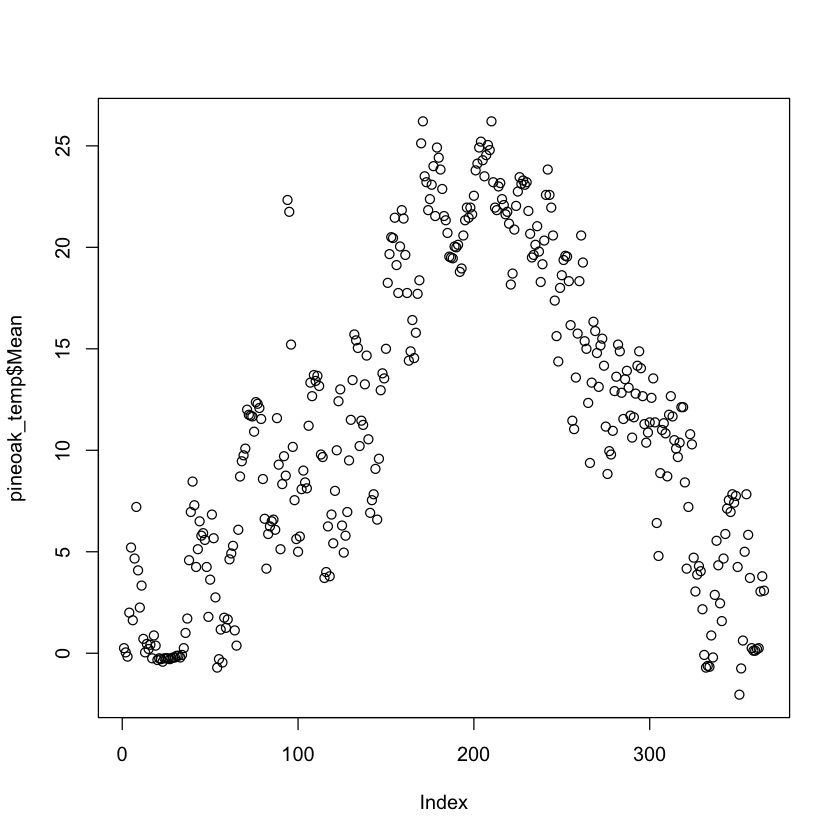

In [47]:
plot(pineoak_temp$Mean)

## `Subalpine`

In [48]:
subalpine.data.plot1.3 <- read.csv("soil_temperature/subalpine_plot1_04-20-17-2.csv", skip=14)
subalpine.data.plot1.2 <- read.csv("soil_temperature/subalpine_plot1_10-23-16-2.csv", skip=14)
subalpine.data.plot1.1 <- read.csv("soil_temperature/subalpine_plot1_06_16-2.csv",    skip=14)

#had to go in and open up a new excel sheet, copy and paste to a new spread sheet, it converted, then saved
subalpine.data.plot4.3 <- read.csv("soil_temperature/subalpine_plot4_04-20-17-2.csv", skip=14)
subalpine.data.plot4.2 <- read.csv("soil_temperature/subalpine_plot4_10-23-16-2.csv", skip=14)
subalpine.data.plot4.1 <- read.csv("soil_temperature/subalpine_plot4_06_16-2.csv",    skip=14)

In [49]:
subalpineplot1 <- rbind(subalpine.data.plot1.1,subalpine.data.plot1.2,subalpine.data.plot1.3 )
head(subalpineplot1)
tail(subalpineplot1)

,Date.Time,Unit,Value
,<fct>,<fct>,<dbl>
1,4/4/16 12:02,C,22.5
2,4/4/16 16:02,C,22.5
3,4/4/16 20:02,C,22.5
4,4/5/16 0:02,C,23.0
5,4/5/16 4:02,C,23.0
6,4/5/16 8:02,C,23.0


,Date.Time,Unit,Value
,<fct>,<fct>,<dbl>
3689,4/19/17 16:02,C,28.0
3690,4/19/17 20:02,C,25.0
3691,4/20/17 0:02,C,20.0
3692,4/20/17 4:02,C,17.0
3693,4/20/17 8:02,C,18.5
3694,4/20/17 12:02,C,26.5


In [50]:
subalpineplot4 <- rbind(subalpine.data.plot4.1,subalpine.data.plot4.2,subalpine.data.plot4.3 )
head(subalpineplot4)
tail(subalpineplot4)

,Date.Time,Unit,Value
,<fct>,<fct>,<dbl>
1,4/4/16 12:01,C,22.5
2,4/4/16 16:01,C,22.5
3,4/4/16 20:01,C,22.5
4,4/5/16 0:01,C,23.0
5,4/5/16 4:01,C,23.0
6,4/5/16 8:01,C,23.0


,Date.Time,Unit,Value
,<fct>,<fct>,<dbl>
3689,4/19/17 16:01,C,30.0
3690,4/19/17 20:01,C,25.5
3691,4/20/17 0:01,C,22.0
3692,4/20/17 4:01,C,18.5
3693,4/20/17 8:01,C,18.5
3694,4/20/17 12:01,C,27.5


In [51]:
subalpine.temp <- maketempdataframe(subalpineplot1, subalpineplot4,"Subalpine")
head(subalpine.temp)
tail(subalpine.temp)

,Date.Time,Unit,Value.Plot1,Date.Time.Plot4,Unit.Plot4,Value.Plot4,Date.Month.Year.Hour,hour,Date,month,year,days,DateandTime,Value.Mean,daynight,site
,<fct>,<fct>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<fct>,<date>,<chr>,<ord>,<ord>,<dttm>,<dbl>,<fct>,<fct>
1,4/4/16 12:02,C,22.5,4/4/16 12:01,C,22.5,4/4/16 12,12,0016-04-04,Apr,16,4,0016-04-04 12:02:00,22.5,day,Subalpine
2,4/4/16 16:02,C,22.5,4/4/16 16:01,C,22.5,4/4/16 16,16,0016-04-04,Apr,16,4,0016-04-04 16:02:00,22.5,day,Subalpine
3,4/4/16 20:02,C,22.5,4/4/16 20:01,C,22.5,4/4/16 20,20,0016-04-04,Apr,16,4,0016-04-04 20:02:00,22.5,night,Subalpine
4,4/5/16 0:02,C,23.0,4/5/16 0:01,C,23.0,4/5/16 0,0,0016-04-05,Apr,16,5,0016-04-05 00:02:00,23.0,night,Subalpine
5,4/5/16 4:02,C,23.0,4/5/16 4:01,C,23.0,4/5/16 4,4,0016-04-05,Apr,16,5,0016-04-05 04:02:00,23.0,night,Subalpine
6,4/5/16 8:02,C,23.0,4/5/16 8:01,C,23.0,4/5/16 8,8,0016-04-05,Apr,16,5,0016-04-05 08:02:00,23.0,night,Subalpine


,Date.Time,Unit,Value.Plot1,Date.Time.Plot4,Unit.Plot4,Value.Plot4,Date.Month.Year.Hour,hour,Date,month,year,days,DateandTime,Value.Mean,daynight,site
,<fct>,<fct>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<fct>,<date>,<chr>,<ord>,<ord>,<dttm>,<dbl>,<fct>,<fct>
3689,4/19/17 16:02,C,28.0,4/19/17 16:01,C,30.0,4/19/17 16,16,0017-04-19,Apr,17,19,0017-04-19 16:02:00,29.00,day,Subalpine
3690,4/19/17 20:02,C,25.0,4/19/17 20:01,C,25.5,4/19/17 20,20,0017-04-19,Apr,17,19,0017-04-19 20:02:00,25.25,night,Subalpine
3691,4/20/17 0:02,C,20.0,4/20/17 0:01,C,22.0,4/20/17 0,0,0017-04-20,Apr,17,20,0017-04-20 00:02:00,21.00,night,Subalpine
3692,4/20/17 4:02,C,17.0,4/20/17 4:01,C,18.5,4/20/17 4,4,0017-04-20,Apr,17,20,0017-04-20 04:02:00,17.75,night,Subalpine
3693,4/20/17 8:02,C,18.5,4/20/17 8:01,C,18.5,4/20/17 8,8,0017-04-20,Apr,17,20,0017-04-20 08:02:00,18.50,night,Subalpine
3694,4/20/17 12:02,C,26.5,4/20/17 12:01,C,27.5,4/20/17 12,12,0017-04-20,Apr,17,20,0017-04-20 12:02:00,27.00,day,Subalpine


In [52]:
subalpine.temp0 <- subalpine.temp[c('Date','Value.Mean')]
head(subalpine.temp0)

,Date,Value.Mean
,<date>,<dbl>
1,0016-04-04,22.5
2,0016-04-04,22.5
3,0016-04-04,22.5
4,0016-04-05,23.0
5,0016-04-05,23.0
6,0016-04-05,23.0


In [53]:
subalpine.temp1 <- ddply(subalpine.temp0, .(Date), summarize, Mean=mean(Value.Mean))
head(subalpine.temp1)

,Date,Mean
,<date>,<dbl>
1,0016-04-04,22.500000
2,0016-04-05,20.375000
3,0016-04-06,13.541667
4,0016-04-07,8.583333
5,0016-04-08,5.916667
6,0016-04-09,4.333333


In [54]:
subalpine.temp1$Date

[1] "0016-04-04" "0016-04-05" "0016-04-06" "0016-04-07" "0016-04-08"
  [6] "0016-04-09" "0016-04-10" "0016-04-11" "0016-04-12" "0016-04-13"
 [11] "0016-04-14" "0016-04-15" "0016-04-16" "0016-04-17" "0016-04-18"
 [16] "0016-04-19" "0016-04-20" "0016-04-21" "0016-04-22" "0016-04-23"
 [21] "0016-04-24" "0016-04-25" "0016-04-26" "0016-04-27" "0016-04-28"
 [26] "0016-04-29" "0016-04-30" "0016-05-01" "0016-05-02" "0016-05-03"
 [31] "0016-05-04" "0016-05-05" "0016-05-06" "0016-05-07" "0016-05-08"
 [36] "0016-05-09" "0016-05-10" "0016-05-11" "0016-05-12" "0016-05-13"
 [41] "0016-05-14" "0016-05-15" "0016-05-16" "0016-05-17" "0016-05-18"
 [46] "0016-05-19" "0016-05-20" "0016-05-21" "0016-05-22" "0016-05-23"
 [51] "0016-05-24" "0016-05-25" "0016-05-26" "0016-05-27" "0016-05-28"
 [56] "0016-05-29" "0016-05-30" "0016-05-31" "0016-06-01" "0016-06-02"
 [61] "0016-06-03" "0016-06-04" "0016-06-05" "0016-06-06" "0016-06-07"
 [66] "0016-06-08" "0016-06-09" "0016-06-10" "0016-06-11" "0016-06-12"
 [71] "0016-06-13" "0016-06-14" "0016-06-15" "0016-06-16" "0016-06-17"
 [76] "0016-06-18" "0016-06-19" "0016-06-20" "0016-06-21" "0016-06-22"
 [81] "0016-06-23" "0016-06-24" "0016-06-25" "0016-06-26" "0016-06-27"
 [86] "0016-06-28" "0016-06-29" "0016-06-30" "0016-07-01" "0016-07-02"
 [91] "0016-07-03" "0016-07-04" "0016-07-05" "0016-07-06" "0016-07-07"
 [96] "0016-07-08" "0016-07-09" "0016-07-10" "0016-07-11" "0016-07-12"
[101] "0016-07-13" "0016-07-14" "0016-07-15" "0016-07-16" "0016-07-17"
[106] "0016-07-18" "0016-07-19" "0016-07-20" "0016-07-21" "0016-07-22"
[111] "0016-07-23" "0016-07-24" "0016-07-25" "0016-07-26" "0016-07-27"
[116] "0016-07-28" "0016-07-29" "0016-07-30" "0016-07-31" "0016-08-01"
[121] "0016-08-02" "0016-08-03" "0016-08-04" "0016-08-05" "0016-08-06"
[126] "0016-08-07" "0016-08-08" "0016-08-09" "0016-08-10" "0016-08-11"
[131] "0016-08-12" "0016-08-13" "0016-08-14" "0016-08-15" "0016-08-16"
[136] "0016-08-17" "0016-08-18" "0016-08-19" "0016-08-20" "0016-08-21"
[141] "0016-08-22" "0016-08-23" "0016-08-24" "0016-08-25" "0016-08-26"
[146] "0016-08-27" "0016-08-28" "0016-08-29" "0016-08-30" "0016-08-31"
[151] "0016-09-01" "0016-09-02" "0016-09-03" "0016-09-04" "0016-09-05"
[156] "0016-09-06" "0016-09-07" "0016-09-08" "0016-09-09" "0016-09-10"
[161] "0016-09-11" "0016-09-12" "0016-09-13" "0016-09-14" "0016-09-15"
[166] "0016-09-16" "0016-09-17" "0016-09-18" "0016-09-19" "0016-09-20"
[171] "0016-09-21" "0016-09-22" "0016-09-23" "0016-09-24" "0016-09-25"
[176] "0016-09-26" "0016-09-27" "0016-09-28" "0016-09-29" "0016-09-30"
[181] "0016-10-01" "0016-10-02" "0016-10-03" "0016-10-04" "0016-10-05"
[186] "0016-10-06" "0016-10-07" "0016-10-08" "0016-10-09" "0016-10-10"
[191] "0016-10-11" "0016-10-12" "0016-10-13" "0016-10-14" "0016-10-15"
[196] "0016-10-16" "0016-10-17" "0016-10-18" "0016-10-19" "0016-10-20"
[201] "0016-10-21" "0016-10-22" "0016-10-23" "0016-10-24" "0016-10-25"
[206] "0016-10-26" "0016-10-27" "0016-10-28" "0016-10-29" "0016-10-30"
[211] "0016-10-31" "0016-11-01" "0016-11-02" "0016-11-03" "0016-11-04"
[216] "0016-11-05" "0016-11-06" "0016-11-07" "0016-11-08" "0016-11-09"
[221] "0016-11-10" "0016-11-11" "0016-11-12" "0016-11-13" "0016-11-14"
[226] "0016-11-15" "0016-11-16" "0016-11-17" "0016-11-18" "0016-11-19"
[231] "0016-11-20" "0016-11-21" "0016-11-22" "0016-11-23" "0016-11-24"
[236] "0016-11-25" "0016-11-26" "0016-11-27" "0016-11-28" "0016-11-29"
[241] "0016-11-30" "0016-12-01" "0016-12-02" "0016-12-03" "0016-12-04"
[246] "0016-12-05" "0016-12-06" "0016-12-07" "0016-12-08" "0016-12-09"
[251] "0016-12-10" "0016-12-11" "0016-12-12" "0016-12-13" "0016-12-14"
[256] "0016-12-15" "0016-12-16" "0016-12-17" "0016-12-18" "0016-12-19"
[261] "0016-12-20" "0016-12-21" "0016-12-22" "0016-12-23" "0016-12-24"
[266] "0016-12-25" "0016-12-26" "0016-12-27" "0016-12-28" "0016-12-29"
[271] "0016-12-30" "0016-12-31" "0017-01-01" "0017-01-02" "0017-01-03"
[276] "0017-01-04" "0017-01-05" "0017-01-06" "0017-01-07" "0017-01-08"
[281] "0017-01-09" "0017-0

In [55]:
index1 <- subalpine.temp1$Date>='0017-01-01' & subalpine.temp1$Date<='0017-04-03'
index2 <- subalpine.temp1$Date<='0016-12-31'

subalpine_temp <- rbind(subalpine.temp1[index1,], subalpine.temp1[index2,])
head(subalpine_temp)

,Date,Mean
,<date>,<dbl>
273,0017-01-01,0.2083333
274,0017-01-02,0.1250000
275,0017-01-03,0.1250000
276,0017-01-04,0.3333333
277,0017-01-05,0.7916667
278,0017-01-06,-0.4583333


In [56]:
rownames(subalpine_temp) <- 1:365
head(subalpine_temp)
tail(subalpine_temp)

,Date,Mean
,<date>,<dbl>
1,0017-01-01,0.2083333
2,0017-01-02,0.1250000
3,0017-01-03,0.1250000
4,0017-01-04,0.3333333
5,0017-01-05,0.7916667
6,0017-01-06,-0.4583333


,Date,Mean
,<date>,<dbl>
360,0016-12-26,0.04166667
361,0016-12-27,0.25000000
362,0016-12-28,0.25000000
363,0016-12-29,0.25000000
364,0016-12-30,0.29166667
365,0016-12-31,0.29166667


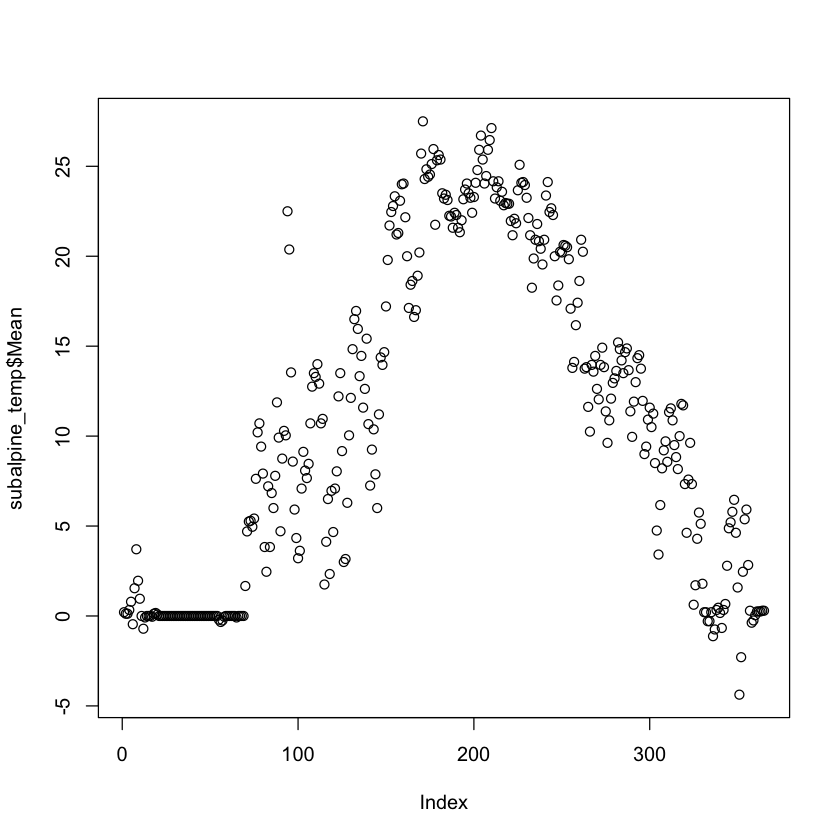

In [57]:
plot(subalpine_temp$Mean)

### Pool data of all of the 5 sites togother 

In [84]:
site_temp <- data.frame(cbind(desert_temp$Mean,scrubland_temp$Mean,grassland_temp$Mean, pineoak_temp$Mean, subalpine_temp$Mean))
names(site_temp) <- c('desert', 'scrubland', 'grassland','pineoak', 'subalpine')

In [85]:
dim(site_temp)
head(site_temp)

[1] 365   5

,desert,scrubland,grassland,pineoak,subalpine
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,11.416667,4.000000,6.500000,0.25000000,0.2083333
2,9.958333,4.333333,9.000000,0.04166667,0.1250000
3,9.375000,5.250000,7.916667,-0.16666667,0.1250000
4,9.666667,9.291667,8.625000,2.00000000,0.3333333
5,13.916667,10.041667,12.583333,5.20833333,0.7916667
6,12.166667,4.333333,8.750000,1.62500000,-0.4583333


In [86]:
write.csv(site_temp,"./soil_temperature/sites_temperature.csv")